In [292]:
% run qpfs_class_draft.ipynb

In [293]:
% run Analysys\ Draft.ipynb

[ 1.  0.  0.  0.  1.]
{'VIF': 3, 'Det Coef': 2, "Mallow's Cp": 5, 'Adj Det Coef': 1, 'BIC': 4, 'RSS': 0}


In [294]:
class Selector():
    def __init__(self, algo):
        self.algo = algo
    def fit(self, X, y):
        self.algo.fit(X, y)
    def select(self, num_features):
        return self.algo.select(num_features)

In [295]:
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline
class ModelQuality():
    def __init__(self, selector, model):
        self.model = model
        self.selector = selector
    def fit(self, X, y, ns_features=None, test_size=0.3):
        if ns_features is None:
            ns_features = np.arange(X.shape[1]) + 1
            #print(ns_features)
        self.ns_features = ns_features
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(X, y, 
                                                                                test_size=test_size, random_state=179)
        self.masks = np.zeros((len(ns_features), X.shape[1]), dtype=np.bool)
        self.selector.fit(self.X_train, self.y_train)
        for (i, num) in enumerate(ns_features):
            cur_features = self.selector.select(num)
            self.masks[i][cur_features] = True
    def evaluate(self, metrics = [], comparisons = [], characteristics = [], n_samples=20, mode='static'):
        if mode == 'static':
            self.evaluate_info = EvaluateStaticInfo(self.model, metrics, comparisons)
        else:
            self.evaluate_info = EvaluateDynamicInfo(self.model, metrics, comparisons, characteristics)
        #print(self.X_train)
        #print(self.y_train)
        print(self.evaluate_info)
        self.n_samples = n_samples
        self.evaluate_info.fit(self.X_train, self.y_train, self.X_test, self.y_test, self.masks, n_samples)
        self.result = self.evaluate_info.get_result()
        self.quality = self.evaluate_info.get_quality()
    
    def calc_mean_and_std(self):
        self.mean = np.mean(self.result, axis=-1)
        self.std = np.std(self.result, axis=-1)
    
    def _draw(self, name):
        index = self.evaluate_info.names[name]
        plt.plot(self.ns_features, self.quality[index], label='quality')
        plt.plot(self.ns_features, self.mean[index], label='mean')
        plt.plot(self.ns_features, self.mean[index] + self.std[index], color='navy', label='mean+-std')
        plt.plot(self.ns_features, self.mean[index] - self.std[index], color='navy')
        for i in range(self.n_samples):
            plt.plot(self.ns_features, self.result[index, :, i], color='purple', alpha=0.2)
        plt.legend()
        plt.title(name)
        plt.xlabel('n')
        plt.ylabel(name)
    
    def draw(self, names):
        rows = (len(names)+2) // 2
        plt.figure(figsize=(20, 6 * rows))
        for i in range(len(names)):
            plt.subplot(rows, 2, i+1)
            self._draw(names[i])
        plt.show()
        
        
        
        
            

In [296]:
s = Selector(QPFS())
lin = LinearRegression()

In [297]:
q = ModelQuality(s, lin)

In [298]:
import scipy.stats as sps

XX = sps.norm.rvs(size=(200, 5))
X2 = sps.norm.rvs(size=(10, 5))
zz = sps.uniform.rvs(size=(5, 3))
yy = XX @ zz + sps.norm.rvs(scale=0.1, size=(200, 3))
y2 = X2 @ zz + sps.norm.rvs(scale=0.1, size=(10, 3))
maskk = np.ones(XX.shape[1])
maskk[2]=0
maskk[1] = 0
maskk[3] = 0
print(maskk)

metric1 = RSS()
metric2 = Adjusted_Determination_Coefficient()
metric3 = Determination_Coefficient()
metric4 = VIF()
metric5 = BIC()
char1 = Condition_Number()
comp1 = Cp()

[ 1.  0.  0.  0.  1.]


In [299]:
q.fit(XX, yy)

In [300]:
q.evaluate([metric1, metric2, metric3, metric4, metric5],
                           [comp1], [char1], mode='dynamic')

{'VIF': 3, 'Det Coef': 2, "Mallow's Cp": 5, 'Adj Det Coef': 1, 'BIC': 4, 'RSS': 0, 'Cond number': 6}


In [301]:
q.calc_mean_and_std()
q.evaluate_info.names

{'Adj Det Coef': 1,
 'BIC': 4,
 'Cond number': 6,
 'Det Coef': 2,
 "Mallow's Cp": 5,
 'RSS': 0,
 'VIF': 3}

In [302]:
q.mean.shape

(7, 5)

In [303]:
q.result.shape

(7, 5, 20)

In [304]:
q.std.shape

(7, 5)

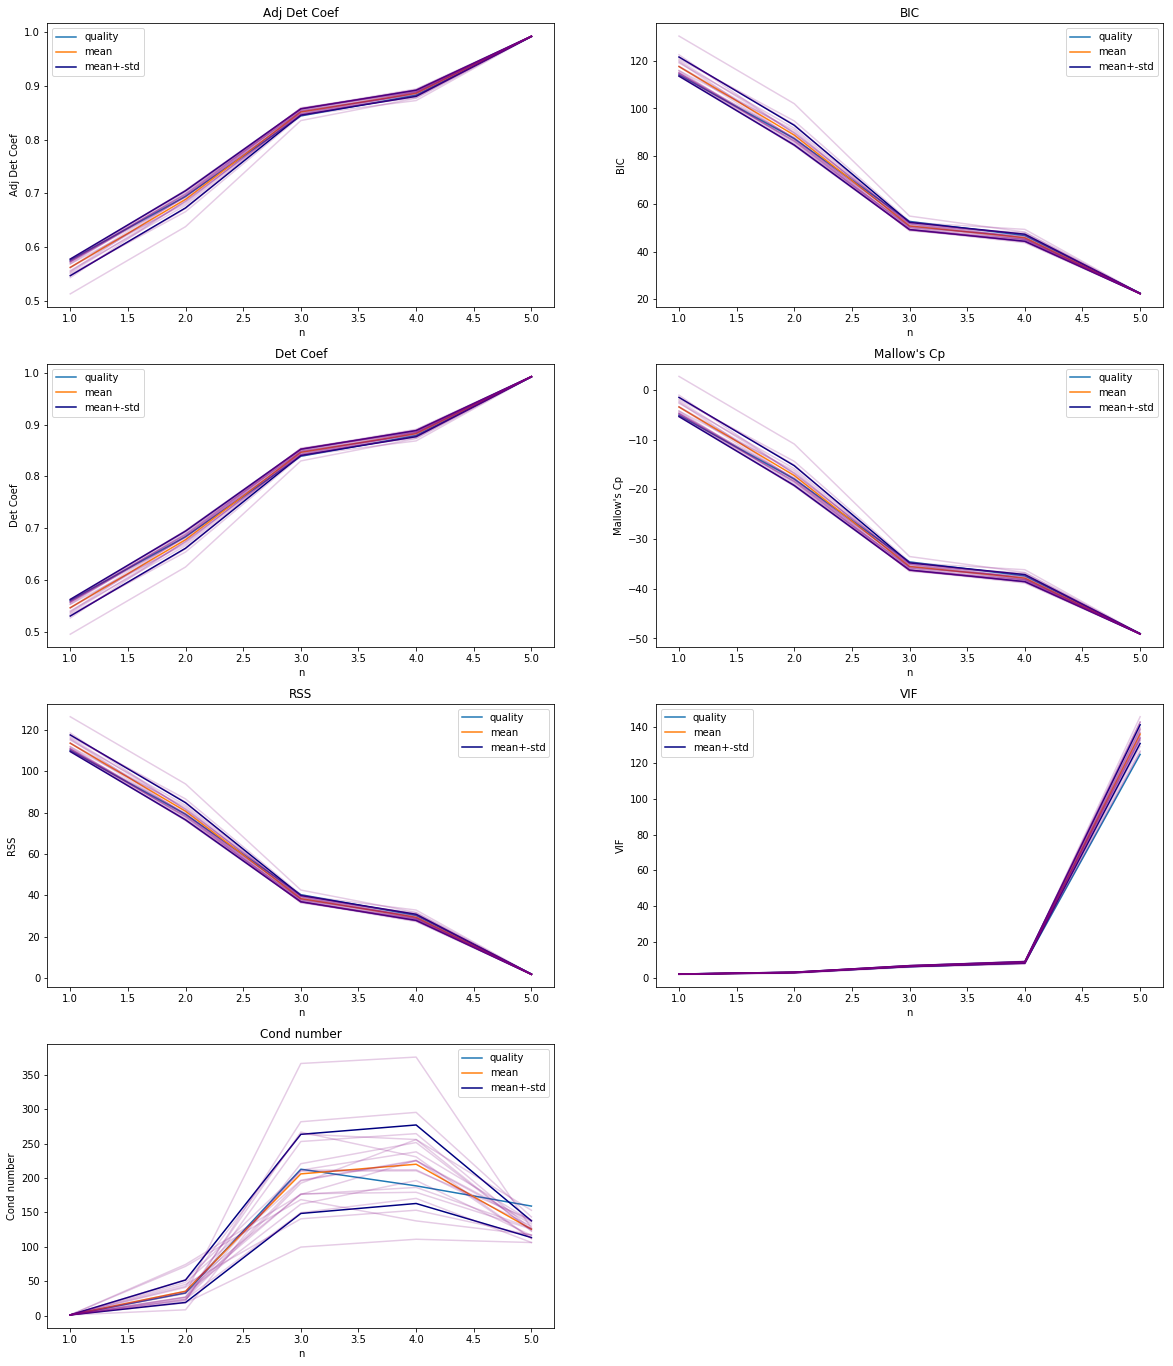

In [305]:
q.draw(['Adj Det Coef','BIC', 'Det Coef', "Mallow's Cp",'RSS', 'VIF', 'Cond number'])